## This model will clasify a potato leaf has any common disease.
Version 01 :
1. Model : Custom
2. Diseaseses : 6 (bacteria / fungi / nematode / pest / phytopthora / virus )
3. Dataset : Potato_bacteria_fungi_nematode_pest_phytopthora_virus_dataset

In [1]:
# Import libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

In [2]:
PATH = 'Datasets//Potato Leaf Disease - Balanced & Augmented'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANELS = 3
EPOCHS = 100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5236 files belonging to 7 classes.


2025-12-27 03:57:00.934070: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-27 03:57:00.934100: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-27 03:57:00.934105: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-27 03:57:00.934120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-27 03:57:00.934130: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_names = dataset.class_names
class_names

['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']

In [5]:
N_CLASSES = len(class_names)
N_CLASSES

7

2025-12-27 03:57:01.367692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


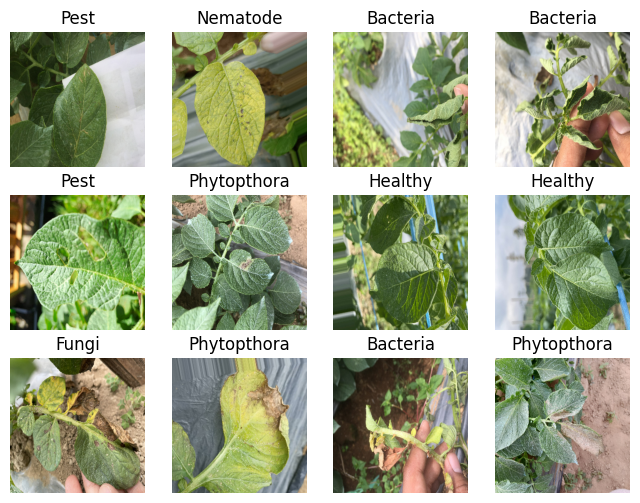

In [6]:
plt.figure(figsize=(8,6))

for image_batch, lable_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[lable_batch[i]])
        plt.axis('off')

In [7]:
#Split the data set into train, test and validation sets.

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    num_batches = len(ds)
    train_size = int(num_batches*train_split)
    val_size = int(num_batches*val_split)

    if shuffle:
        ds.shuffle(shuffle_size, seed=12)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    print('Data partitions are created.')
    print(f'Train size = {len(train_ds)} \nValidation size = {len(val_ds)} \nTest size = {len(test_ds)}')

    return train_ds, val_ds, test_ds

In [8]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

Data partitions are created.
Train size = 131 
Validation size = 16 
Test size = 17


In [9]:
#Set datasets to be cached and work with multi processing

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
#Resize any given image to 256x256 and sacle teh image values to 0:1

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
])

### Model bulding, Training and Evaluating

In [99]:
model_1 = tf.keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(N_CLASSES, activation="softmax")
])

model_1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,047 (371.28 KB)

 Trainable params: 94,599 (369.53 KB)

 Non-trainable params: 448 (1.75 KB)

In [100]:
def save_model(model, name, model_version):
    model.save(f'Models//{name}//{model_version}.keras')
    print('Model saved succesfully')

In [ ]:
model_1.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history_model_1 = model_1.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds
)

save_model(model_1, 'potato_common_diseases_final_models', '2')

Epoch 1/100
 85/131 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.3550 - loss: 1.7399

In [ ]:
score = model_1.evaluate(test_ds)
score

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.8583 - loss: 0.4900


[0.5271403789520264, 0.8552631735801697]

Text(0.5, 1.0, 'Training and Validation loss')

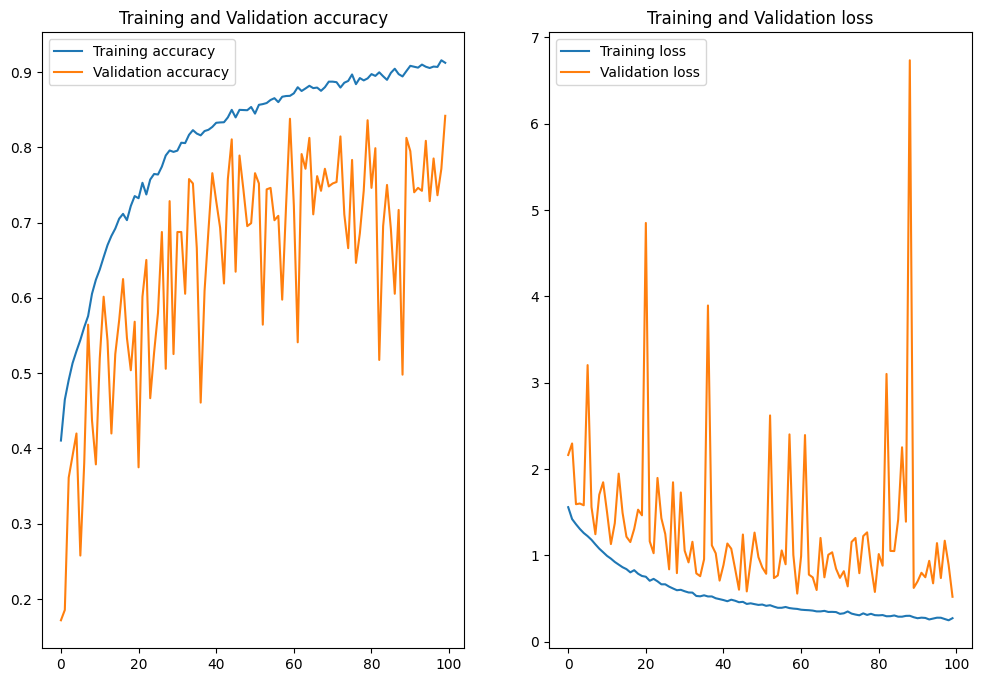

In [ ]:
acc = history_model_1.history['accuracy']
val_acc = history_model_1.history['val_accuracy']

loss = history_model_1.history['loss']
val_loss = history_model_1.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')

In [ ]:
model_2 = tf.keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_CLASSES, activation='softmax')
])

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_model_2 = model_2.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds
)

save_model(model_2, 'potato_common_diseases_final_models', '3')

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.2248 - loss: 1.8137 - val_accuracy: 0.3535 - val_loss: 1.5975
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.3547 - loss: 1.5731 - val_accuracy: 0.3535 - val_loss: 1.5402
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - accuracy: 0.4008 - loss: 1.4980 - val_accuracy: 0.4004 - val_loss: 1.4891
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.4233 - loss: 1.4379 - val_accuracy: 0.3730 - val_loss: 1.4972
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.4519 - loss: 1.3815 - val_accuracy: 0.4707 - val_loss: 1.3307
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - accuracy: 0.4621 - loss: 1.3761 - val_accuracy: 0.4648 - val_loss: 1.3380
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.4894 - loss: 1.2776 - val_accuracy: 0.5195 - val_loss: 1.3005
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 0.5007 -

In [ ]:
score_2 = model_2.evaluate(test_ds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.8193 - loss: 0.5505


Text(0.5, 1.0, 'Training and Validation loss')

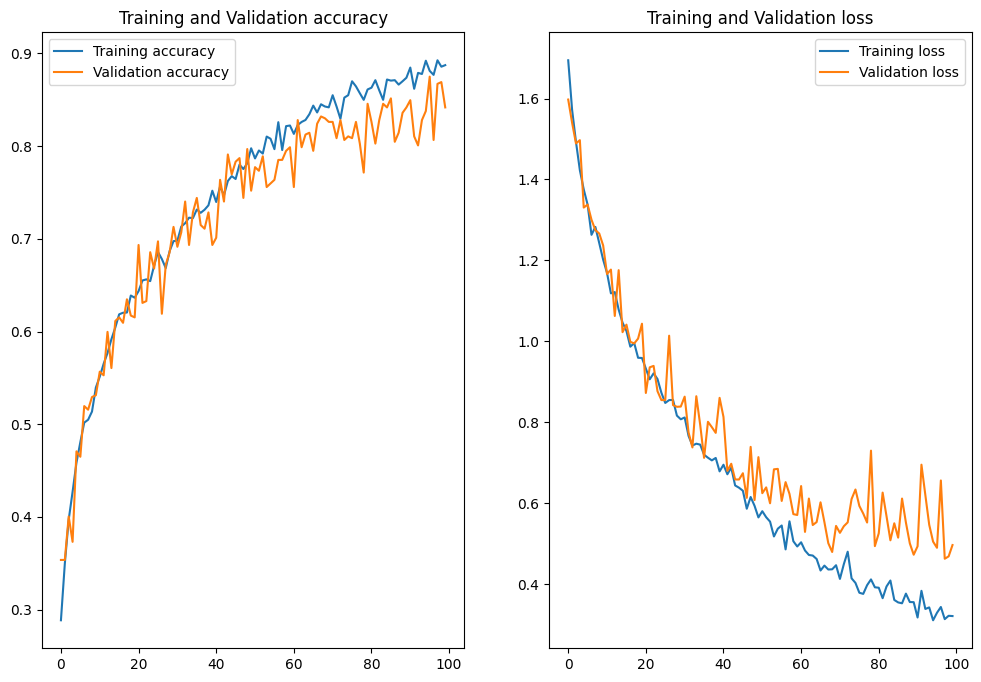

In [ ]:
acc = history_model_2.history['accuracy']
val_acc = history_model_2.history['val_accuracy']

loss = history_model_2.history['loss']
val_loss = history_model_2.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')

### Transferd Model

##### EfficientNetB0

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_model.trainable = False

In [ ]:
model_3 = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(N_CLASSES, activation="softmax"),
])


model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True, verbose=1
    )
]


history_model_3 = model_3.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

save_model(model_3, 'potato_common_diseases_final_models', '4')

Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 253ms/step - accuracy: 0.1474 - loss: 1.9485 - val_accuracy: 0.1289 - val_loss: 1.9459 - learning_rate: 1.0000e-04
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - accuracy: 0.1384 - loss: 1.9477 - val_accuracy: 0.1309 - val_loss: 1.9462 - learning_rate: 1.0000e-04
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - accuracy: 0.1552 - loss: 1.9463 - val_accuracy: 0.1445 - val_loss: 1.9459 - learning_rate: 1.0000e-04
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.1366 - loss: 1.9471
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 167ms/step - accuracy: 0.1367 - loss: 1.9472 - val_accuracy: 0.1309 - val_loss: 1.9467 - learning_rate: 1.0000e-04
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.1355 - loss: 1.9476 - val_accuracy: 0.1309 - val_loss: 1.9464 - learning_rate: 5.0000e-05
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 16

In [ ]:
score = model_3.evaluate(test_ds)
score

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 414ms/step - accuracy: 0.1292 - loss: 1.9460


[1.9459868669509888, 0.13533835113048553]

Text(0.5, 1.0, 'Training and Validation loss')

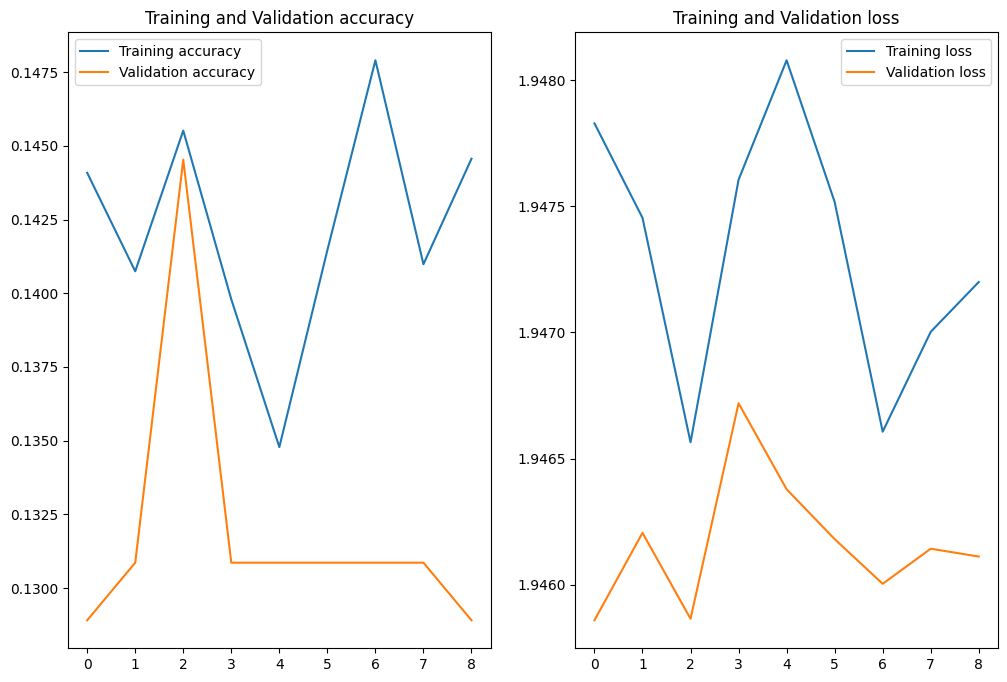

In [ ]:
acc = history_model_3.history['accuracy']
val_acc = history_model_3.history['val_accuracy']

loss = history_model_3.history['loss']
val_loss = history_model_3.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(range(9), acc, label='Training accuracy')
plt.plot(range(9), val_acc, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(9), loss, label='Training loss')
plt.plot(range(9), val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')

##### MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# 1. Use a pre-trained base (Transfer Learning)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False  # Freeze the pre-trained weights

model_4 = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    resize_and_rescale,
    data_augmentation,
    
    base_model,
    
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4), # Increased dropout to fight overfitting
    layers.Dense(N_CLASSES, activation="softmax")
])

model_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6
)

history_model_4 = model_4.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds,
    callbacks=[lr_scheduler]
)

save_model(model_4, 'potato_common_diseases_final_models', '5')

/var/folders/6h/fpw492hx5gvg9pp1vflms7y40000gn/T/ipykernel_44367/1959093451.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.3224 - loss: 1.8504 - val_accuracy: 0.6855 - val_loss: 0.9512 - learning_rate: 0.0010
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.6016 - loss: 1.1157 - val_accuracy: 0.7070 - val_loss: 0.8556 - learning_rate: 0.0010
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.6464 - loss: 0.9775 - val_accuracy: 0.7402 - val_loss: 0.7697 - learning_rate: 0.0010
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.6985 - loss: 0.8565 - val_accuracy: 0.7383 - val_loss: 0.7199 - learning_rate: 0.0010
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.7037 - loss: 0.8316 - val_accuracy: 0.7422 - val_loss: 0.7078 - learning_rate: 0.0010
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.7148 - loss: 0.7914 - val_accuracy: 0.7578 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accura

In [ ]:
score = model_4.evaluate(test_ds)
score

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 325ms/step - accuracy: 0.8106 - loss: 0.5422


[0.5435507893562317, 0.8045112490653992]

Text(0.5, 1.0, 'Training and Validation loss')

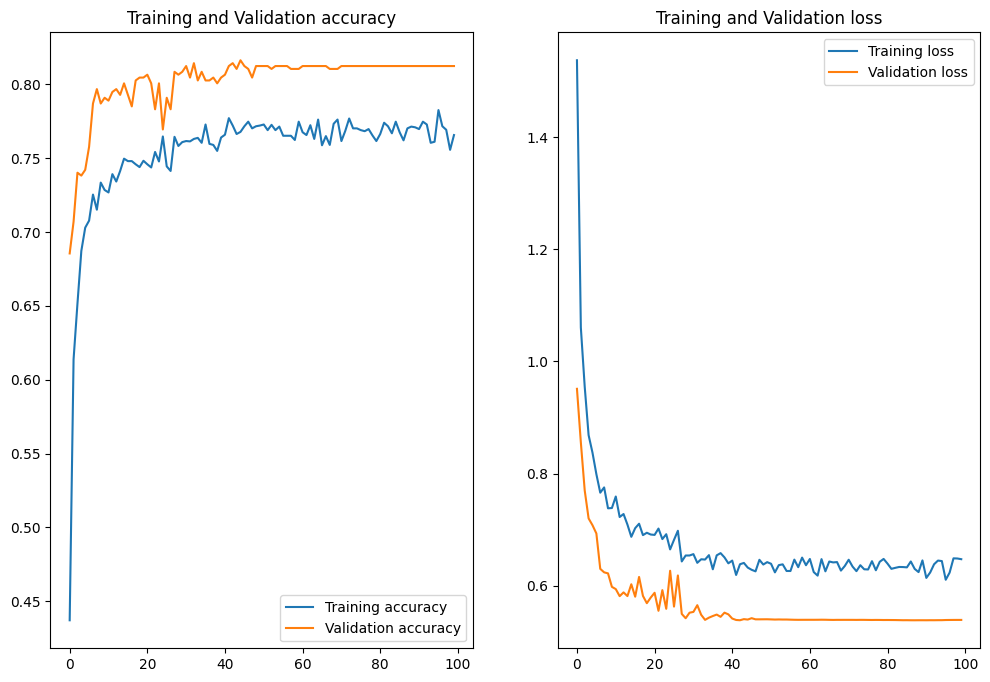

In [ ]:
acc = history_model_4.history['accuracy']
val_acc = history_model_4.history['val_accuracy']

loss = history_model_4.history['loss']
val_loss = history_model_4.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')

In [ ]:
data_augmentation_2 = tf.keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.1),
])

In [ ]:
# 1. Use a pre-trained base (Transfer Learning)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100 

# Freeze all layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model_7 = tf.keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    resize_and_rescale,
    data_augmentation_2,
    
    base_model,
    
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4), # Increased dropout to fight overfitting
    layers.Dense(N_CLASSES, activation="softmax")
])

model_7.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler_2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6
)

history_model_7 = model_7.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds,
    callbacks=[lr_scheduler_2]
)

save_model(model_7, 'potato_common_diseases_final_models', '7')

/var/folders/6h/fpw492hx5gvg9pp1vflms7y40000gn/T/ipykernel_44367/2578232033.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 69s 413ms/step - accuracy: 0.6095 - loss: 1.0446 - val_accuracy: 0.3066 - val_loss: 9.4188 - learning_rate: 0.0010
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 285ms/step - accuracy: 0.8134 - loss: 0.5432 - val_accuracy: 0.1309 - val_loss: 28.2461 - learning_rate: 0.0010
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - accuracy: 0.8471 - loss: 0.4367 - val_accuracy: 0.1289 - val_loss: 29.7159 - learning_rate: 0.0010
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 272ms/step - accuracy: 0.8746 - loss: 0.3747 - val_accuracy: 0.3340 - val_loss: 11.0733 - learning_rate: 0.0010
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 276ms/step - accuracy: 0.8683 - loss: 0.3630 - val_accuracy: 0.1816 - val_loss: 18.5308 - learning_rate: 0.0010
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - accuracy: 0.8742 - loss: 0.3618 - val_accuracy: 0.4902 - val_loss: 4.5625 - learning_rate: 0.0010
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - ac

Text(0.5, 1.0, 'Training and Validation loss')

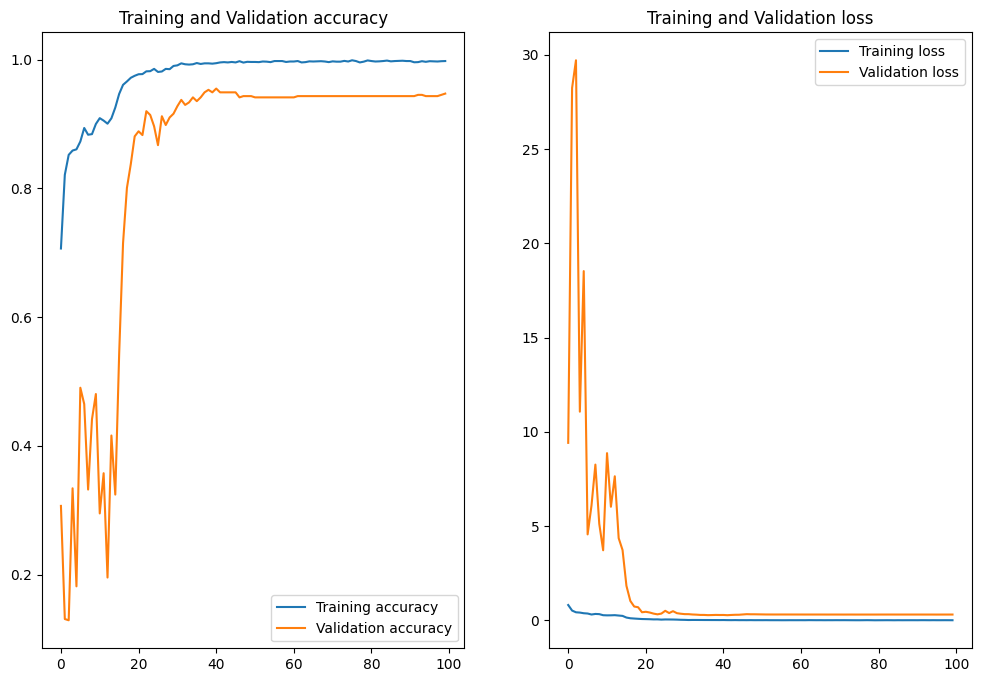

In [66]:
acc = history_model_7.history['accuracy']
val_acc = history_model_7.history['val_accuracy']

loss = history_model_7.history['loss']
val_loss = history_model_7.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')

In [ ]:
score = model_7.evaluate(test_ds)
score

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9067 - loss: 0.4257


[0.400786429643631, 0.9154135584831238]

#### The model_7 gets 91% accuracy in test sets.

2025-12-27 03:58:51.158399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-27 03:58:55.660431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


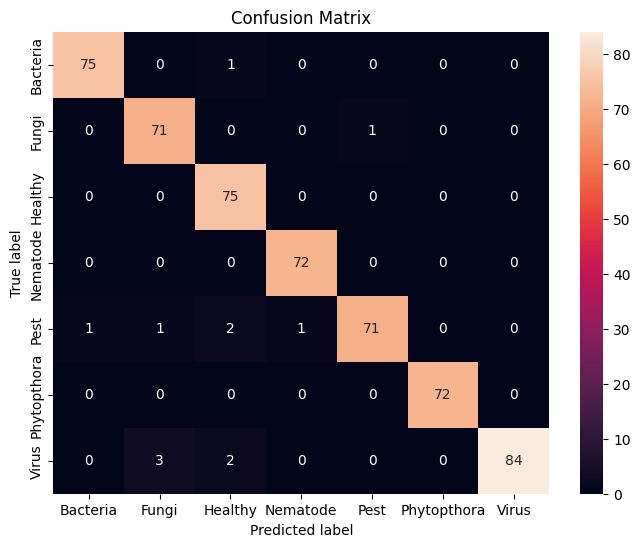

In [12]:
model_7 = tf.keras.models.load_model('Models//potato_common_diseases_final_models//7.keras')

y_true_list = []
y_pred_list = []

for x_batch, y_batch in test_ds:
    probs = model_7.predict_on_batch(x_batch)
    y_true_list.append(y_batch.numpy())
    y_pred_list.append(np.argmax(probs, axis=1))

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns  # if installed

class_names = dataset.class_names  # from image_dataset_from_directory

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


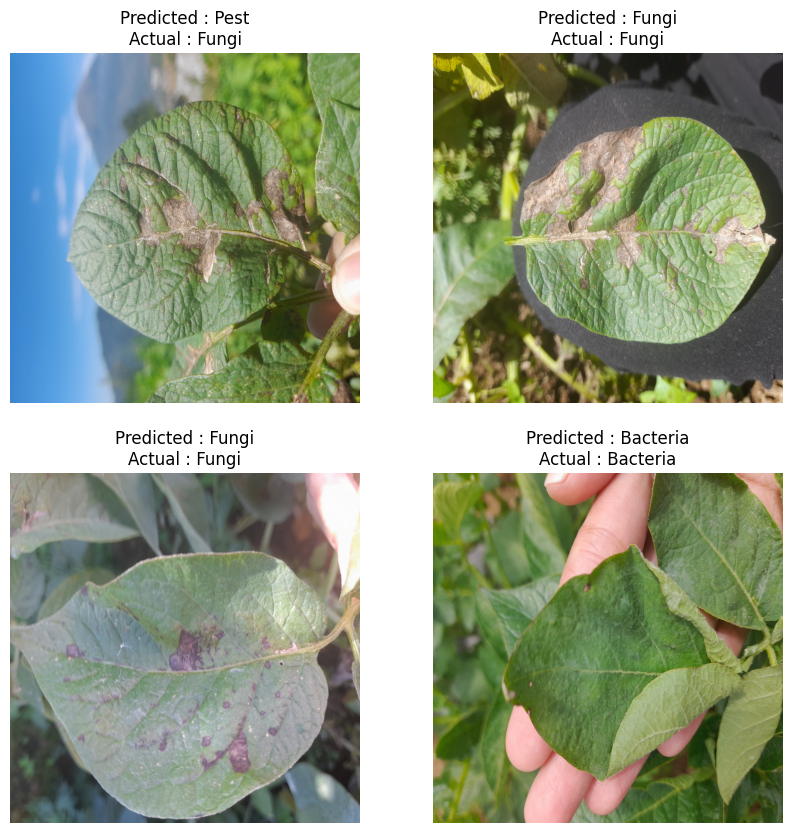

In [70]:
test_imgs = ['20230712_114552.jpg', '20230712_115213.jpg', '20230712_122415.jpg', '20230815_111336.jpg']
titles = ['Fungi', 'Fungi', 'Fungi', 'Bacteria']
plt.figure(figsize=(10,10))

for i in range(len(test_imgs)):
    plt.subplot(2,2,i+1)
    img = cv.cvtColor(cv.imread(f'Extranal_tests//Blight//{test_imgs[i]}'), cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    predict = model_7.predict(tf.expand_dims(img, axis=0))
    plt.title(f'Predicted : {class_names[np.argmax(predict[0])]}\nActual : {titles[i]}')

In [13]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [14]:
import keras
print(keras.__version__)

3.3.3
